# Netflix Content Strategy Analysis

This project analyzes Netflix genre performance using a business-oriented data analytics approach rather than simple exploratory analysis.

Objective

To identify:

Genres with strong long-term growth

Genres that accelerated during COVID

High-volume but volatile segments

Underrated investment opportunitiesGEN2

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import perf_counter

# ---------- tiny timer helper ----------
def timed(name):
    def deco(fn):
        def wrapper(*args, **kwargs):
            t0 = perf_counter()
            out = fn(*args, **kwargs)
            print(f"✅ {name} took {perf_counter()-t0:.4f}s")
            return out
        return wrapper
    return deco


@timed("load_csv")
def load_netflix(csv_path: str) -> pd.DataFrame:
    # low_memory=False prevents dtype guessing across chunks
    return pd.read_csv(csv_path, low_memory=False)


@timed("clean_netflix")
def clean_netflix(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Strip whitespace (vectorized)
    for col in ["type", "title", "director", "cast", "country", "rating", "listed_in"]:
        if col in df.columns:
            df[col] = df[col].astype("string").str.strip()

    # Date parsing (vectorized)
    if "date_added" in df.columns:
        df["date_added"] = pd.to_datetime(df["date_added"], errors="coerce")

    # Release year numeric
    if "release_year" in df.columns:
        df["release_year"] = pd.to_numeric(df["release_year"], errors="coerce").astype("Int16")

    # Duration split (vectorized)
    # Examples: "90 min", "1 Season", "2 Seasons"
    if "duration" in df.columns:
        dur = df["duration"].astype("string").str.strip()

        df["dur_value"] = pd.to_numeric(
            dur.str.extract(r"(\d+)", expand=False),
            errors="coerce"
        ).astype("Int16")

        df["dur_unit"] = dur.str.extract(r"([A-Za-z]+)", expand=False).astype("string")

    return df


@timed("add_features")
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Time features (fast)
    if "date_added" in df.columns:
        df["added_year"] = df["date_added"].dt.year.astype("Int16")
        df["added_month"] = df["date_added"].dt.month.astype("Int8")

    # Multi-value counts (fast)
    # Use fillna("") so split doesn't error
    if "listed_in" in df.columns:
        df["genre_count"] = df["listed_in"].fillna("").str.count(",").add(1).where(df["listed_in"].notna(), 0).astype("Int8")

    if "country" in df.columns:
        df["country_count"] = df["country"].fillna("").str.count(",").add(1).where(df["country"].notna(), 0).astype("Int8")

    # Simple flags
    if "type" in df.columns:
        df["is_movie"] = (df["type"] == "Movie")
        df["is_tv"] = (df["type"] == "TV Show")

    return df


@timed("optimize_dtypes")
def optimize_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Convert some strings to category (big memory win)
    # Only do it for columns with repeated values
    cat_cols = [c for c in ["type", "rating", "dur_unit"] if c in df.columns]
    for c in cat_cols:
        df[c] = df[c].astype("category")

    # Keep text columns as pandas "string" (cleaner than object)
    text_cols = [c for c in ["title", "director", "cast", "country", "listed_in", "description"] if c in df.columns]
    for c in text_cols:
        df[c] = df[c].astype("string")

    return df


@timed("build_genre_long_table")
def build_genre_long_table(df: pd.DataFrame) -> pd.DataFrame:
    g = df.loc[:, ["show_id", "type", "added_year", "listed_in"]].copy()

    g = g[g["listed_in"].notna()]
    g["genre"] = g["listed_in"].str.split(r",\s*")
    g = g.explode("genre", ignore_index=True)

    g["genre"] = g["genre"].astype("category")

    return g.drop(columns=["listed_in"])



@timed("build_country_long_table")
def build_country_long_table(df: pd.DataFrame) -> pd.DataFrame:

    c = df.loc[:, ["show_id", "type", "added_year", "country"]].copy()

    c = c[c["country"].notna()]

    c = (
        c.assign(country=c["country"].str.split(r",\s*"))
         .explode("country", ignore_index=True)
    )

    c["country"] = c["country"].astype("category")

    return c




@timed("build_netflix_pipeline")
def build_netflix_pipeline(csv_path: str):
    df = load_netflix(csv_path)
    df = clean_netflix(df)
    df = add_features(df)
    df = optimize_dtypes(df)

    # Cache long tables once (don’t recompute for every plot)
    df_genres = build_genre_long_table(df)
    df_countries = build_country_long_table(df)

    return df, df_genres, df_countries


# ---- RUN ----
df, df_genres, df_countries = build_netflix_pipeline("netflix_titles.csv")

print("\nQuick check:")
print("df shape:", df.shape)
print("genres long:", df_genres.shape)
print("countries long:", df_countries.shape)


✅ load_csv took 0.0835s
✅ clean_netflix took 0.0554s
✅ add_features took 0.0339s
✅ optimize_dtypes took 0.0279s
✅ build_genre_long_table took 0.0441s
✅ build_country_long_table took 0.0161s
✅ build_netflix_pipeline took 0.2646s

Quick check:
df shape: (8807, 20)
genres long: (19323, 4)
countries long: (10019, 4)


# CONTENT STRATEGY ANALYSIS



In [137]:
@timed("genre_growth_over_time")
def genre_growth_over_time(df_genres: pd.DataFrame) -> pd.DataFrame:
    growth = (
        df_genres
        .groupby(["added_year", "genre"])
        .size()
        .reset_index(name="title_count")
    )
    return growth


In [138]:
genre_growth = genre_growth_over_time(df_genres)
genre_growth.head()


✅ genre_growth_over_time took 0.0123s


/tmp/ipython-input-3602641999.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["added_year", "genre"])


,added_year,genre,title_count
0,2008,Action & Adventure,0
1,2008,Anime Features,0
2,2008,Anime Series,0
3,2008,British TV Shows,0
4,2008,Children & Family Movies,0


/tmp/ipython-input-2119334025.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  genre_growth.groupby("genre")["title_count"]


<Axes: title={'center': 'Top Genre Growth Over Time'}, xlabel='added_year'>

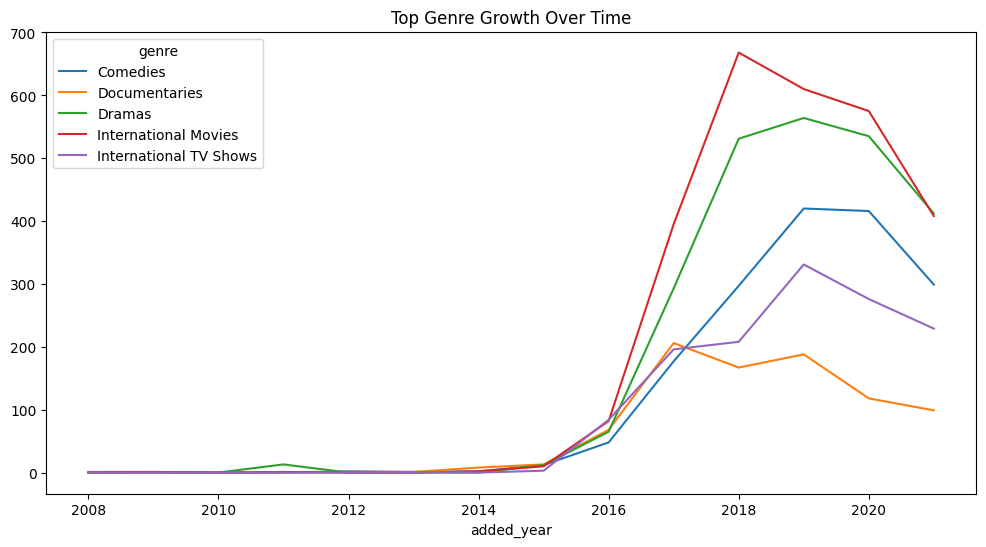

In [139]:
top_genres = (
    genre_growth.groupby("genre")["title_count"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

plot_df = genre_growth[genre_growth["genre"].isin(top_genres)]

pivot = plot_df.pivot(index="added_year", columns="genre", values="title_count").fillna(0)

pivot.plot(figsize=(12,6), title="Top Genre Growth Over Time")


In [140]:
@timed("type_trend")
def type_trend(df: pd.DataFrame) -> pd.DataFrame:
    trend = (
        df.groupby(["added_year", "type"])
        .size()
        .reset_index(name="count")
    )
    return trend


✅ type_trend took 0.0086s


/tmp/ipython-input-978062735.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["added_year", "type"])


<Axes: title={'center': 'Movies vs TV Shows Over Time'}, xlabel='added_year'>

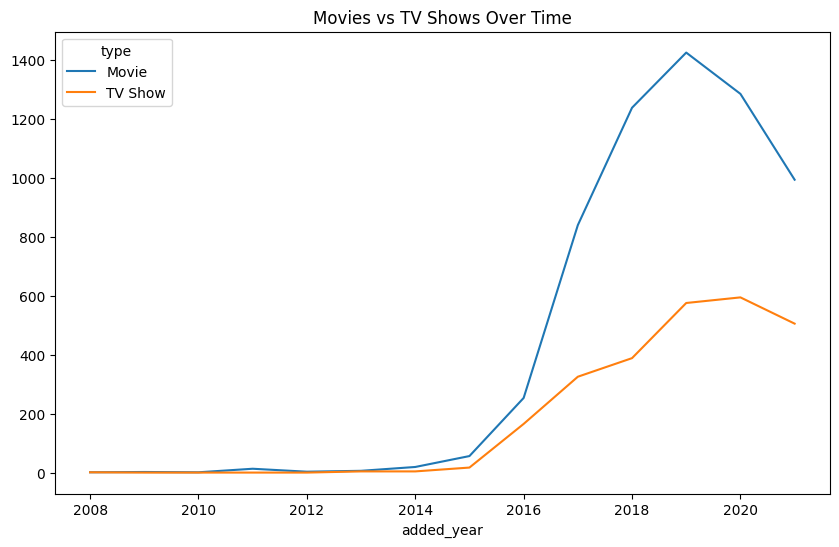

In [141]:
type_growth = type_trend(df)

pivot = type_growth.pivot(index="added_year", columns="type", values="count").fillna(0)
pivot.plot(figsize=(10,6), title="Movies vs TV Shows Over Time")


In [142]:
@timed("release_lag_analysis")
def release_lag_analysis(df: pd.DataFrame) -> pd.DataFrame:
    df["release_lag"] = df["added_year"] - df["release_year"]
    return df


In [143]:
df = release_lag_analysis(df)

df["release_lag"].describe()


✅ release_lag_analysis took 0.0021s


,release_lag
count,8709.0
mean,4.690894
std,8.792208
min,-3.0
25%,0.0
50%,1.0
75%,5.0
max,93.0


<Axes: >

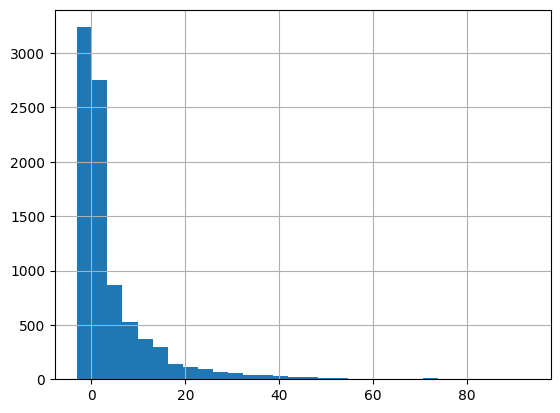

In [144]:
df["release_lag"].hist(bins=30)


In [145]:
@timed("country_growth")
def country_growth(df_countries: pd.DataFrame) -> pd.DataFrame:
    growth = (
        df_countries
        .groupby(["added_year", "country"])
        .size()
        .reset_index(name="count")
    )
    return growth


In [146]:
country_totals = (
    df_countries.groupby("country").size().sort_values(ascending=False)
)

country_totals.head(10)


/tmp/ipython-input-3177672552.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_countries.groupby("country").size().sort_values(ascending=False)


,0
country,
United States,3690
India,1046
United Kingdom,806
Canada,445
France,393
Japan,318
Spain,232
South Korea,231
Germany,226


Between 2016–2019 Netflix aggressively expanded International Movies and TV content while increasing production of series, signaling a global localization strategy

In [147]:
# Computing genre growth

@timed("genre_growth_over_time")
def genre_growth_over_time(df_genres: pd.DataFrame) -> pd.DataFrame:
    growth = (
        df_genres
        .groupby(["added_year", "genre"])
        .size()
        .reset_index(name="title_count")
        .sort_values(["genre", "added_year"])
    )
    return growth


In [148]:
genre_growth = genre_growth_over_time(df_genres)
genre_growth.head()


✅ genre_growth_over_time took 0.0098s


/tmp/ipython-input-3848941546.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["added_year", "genre"])


,added_year,genre,title_count
0,2008,Action & Adventure,0
42,2009,Action & Adventure,0
84,2010,Action & Adventure,0
126,2011,Action & Adventure,0
168,2012,Action & Adventure,0


In [149]:
# Focusing on Strategic Genres (Top 5 Overall)

top_genres = (
    genre_growth.groupby("genre")["title_count"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

top_genres


/tmp/ipython-input-3326353423.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  genre_growth.groupby("genre")["title_count"]


CategoricalIndex(['International Movies', 'Dramas', 'Comedies', 'International TV Shows', 'Documentaries'], categories=['Action & Adventure', 'Anime Features', 'Anime Series', 'British TV Shows', ..., 'TV Shows', 'TV Thrillers', 'Teen TV Shows', 'Thrillers'], ordered=False, dtype='category', name='genre')

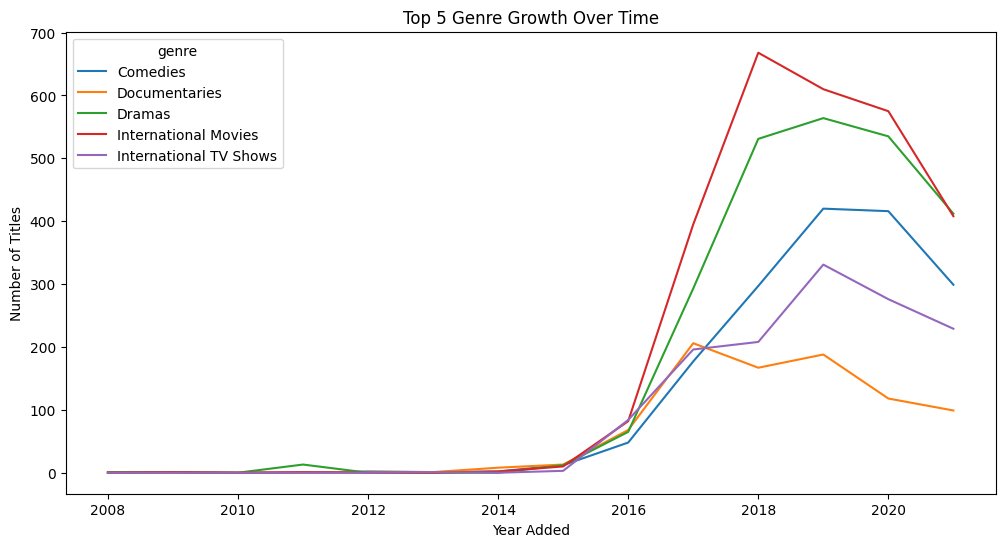

In [150]:
# Plotting the growth of top genre

plot_df = genre_growth[genre_growth["genre"].isin(top_genres)]

pivot = (
    plot_df
    .pivot(index="added_year", columns="genre", values="title_count")
    .fillna(0)
)

pivot.plot(figsize=(12,6))
plt.title("Top 5 Genre Growth Over Time")
plt.xlabel("Year Added")
plt.ylabel("Number of Titles")
plt.show()


In [151]:
def compute_genre_growth_rate(genre_growth):
    pivot = (
        genre_growth
        .pivot(index="added_year", columns="genre", values="title_count")
        .fillna(0)
    )

    growth_rate = pivot.pct_change() * 100
    return growth_rate


In [152]:
# 1) Yearly title counts per genre (long)
genre_year_counts = (
    df_genres
    .groupby(["added_year", "genre"])
    .size()
    .reset_index(name="title_count")
)

# 2) Wide table: rows=year, cols=genre, values=counts
genre_growth = (
    genre_year_counts
    .pivot(index="added_year", columns="genre", values="title_count")
    .fillna(0)
    .sort_index()
)

genre_growth.head()


/tmp/ipython-input-1511225139.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["added_year", "genre"])


genre,Action & Adventure,Anime Features,Anime Series,British TV Shows,Children & Family Movies,Classic & Cult TV,Classic Movies,Comedies,Crime TV Shows,Cult Movies,Documentaries,Docuseries,Dramas,Faith & Spirituality,Horror Movies,Independent Movies,International Movies,International TV Shows,Kids' TV,Korean TV Shows,LGBTQ Movies,Movies,Music & Musicals,Reality TV,Romantic Movies,Romantic TV Shows,Sci-Fi & Fantasy,Science & Nature TV,Spanish-Language TV Shows,Sports Movies,Stand-Up Comedy,Stand-Up Comedy & Talk Shows,TV Action & Adventure,TV Comedies,TV Dramas,TV Horror,TV Mysteries,TV Sci-Fi & Fantasy,TV Shows,TV Thrillers,Teen TV Shows,Thrillers
added_year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2009,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2010,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2011,0,0,0,0,1,0,0,0,0,0,0,0,13,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1
2012,0,0,0,0,1,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [153]:
# Removeing any non-genre columns if they somehow exist
genre_growth = genre_growth.loc[:, genre_growth.columns.notna()]

# Force everything to numeric (fixes dtype issues)
genre_growth = genre_growth.apply(pd.to_numeric, errors="coerce").fillna(0)

# Make values ints
genre_growth = genre_growth.round(0).astype(int)

genre_growth.dtypes.head()


,0
genre,
Action & Adventure,int64
Anime Features,int64
Anime Series,int64
British TV Shows,int64
Children & Family Movies,int64


In [154]:
genre_yoy_growth = genre_growth.pct_change() * 100
genre_yoy_growth.tail()


genre,Action & Adventure,Anime Features,Anime Series,British TV Shows,Children & Family Movies,Classic & Cult TV,Classic Movies,Comedies,Crime TV Shows,Cult Movies,Documentaries,Docuseries,Dramas,Faith & Spirituality,Horror Movies,Independent Movies,International Movies,International TV Shows,Kids' TV,Korean TV Shows,LGBTQ Movies,Movies,Music & Musicals,Reality TV,Romantic Movies,Romantic TV Shows,Sci-Fi & Fantasy,Science & Nature TV,Spanish-Language TV Shows,Sports Movies,Stand-Up Comedy,Stand-Up Comedy & Talk Shows,TV Action & Adventure,TV Comedies,TV Dramas,TV Horror,TV Mysteries,TV Sci-Fi & Fantasy,TV Shows,TV Thrillers,Teen TV Shows,Thrillers
added_year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017,438.888889,125.000000,-21.428571,138.888889,290.000000,600.000000,650.000000,268.750000,169.565217,300.000000,202.941176,85.185185,350.769231,400.000000,337.500000,274.193548,381.707317,133.333333,2.500000,244.444444,700.000000,-66.666667,307.692308,160.000000,800.000000,30.952381,200.000000,90.000000,280.000000,118.750000,61.538462,inf,220.000000,52.777778,220.512821,33.333333,200.000000,233.333333,0.000000,0.000000,33.333333,385.714286
2018,78.350515,-22.222222,90.909091,-11.627907,8.974359,-57.142857,-73.333333,67.796610,30.645161,200.000000,-18.932039,24.000000,81.228669,300.000000,122.857143,40.517241,69.113924,6.122449,41.463415,-54.838710,25.000000,375.000000,81.132075,176.923077,71.428571,-21.818182,166.666667,-42.105263,47.368421,-2.857143,41.269841,100.000000,25.000000,72.727273,-17.600000,150.000000,66.666667,-10.000000,0.000000,0.000000,50.000000,63.235294
2019,16.763006,100.000000,95.238095,47.368421,72.941176,-66.666667,1000.000000,41.414141,34.567901,83.333333,12.574850,35.483871,6.214689,-5.000000,24.358974,23.312883,-8.682635,59.134615,39.655172,271.428571,-5.000000,-63.157895,-19.791667,55.555556,38.888889,123.255814,25.000000,45.454545,28.571429,64.705882,-25.842697,-50.000000,95.000000,18.947368,57.281553,80.000000,6.666667,66.666667,50.000000,140.000000,200.000000,21.621622
2020,-15.841584,0.000000,9.756098,-21.428571,15.646259,500.000000,-34.090909,-0.952381,-6.422018,-40.909091,-37.234043,-4.761905,-5.141844,-42.105263,-20.618557,-26.368159,-5.737705,-16.616314,33.333333,-42.307692,47.368421,-28.571429,-5.194805,42.857143,15.333333,-30.208333,-32.857143,0.000000,-5.555556,-26.785714,-27.272727,-11.111111,10.256410,11.504425,1.234568,22.222222,75.000000,53.333333,-33.333333,8.333333,5.555556,-1.481481
2021,15.294118,64.285714,-11.111111,-31.818182,-28.235294,-50.000000,-24.137931,-28.125000,-23.529412,38.461538,-16.101695,-11.250000,-22.990654,-27.272727,-24.675325,-39.864865,-29.043478,-17.028986,-9.259259,-63.333333,-42.857143,40.000000,-23.287671,-32.500000,-34.104046,-10.447761,-19.148936,-25.000000,35.294118,-26.829268,-64.583333,0.000000,-13.953488,-6.349206,-16.463415,-36.363636,-21.428571,-13.043478,150.000000,0.000000,-5.263158,-15.789474


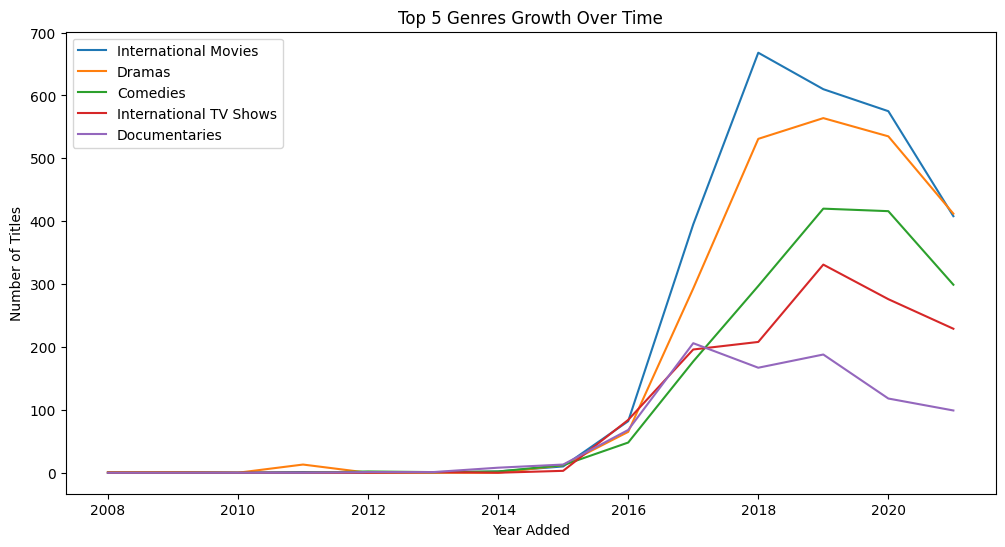

In [155]:
top5_genres = genre_growth.sum(axis=0).sort_values(ascending=False).head(5).index
plot_df = genre_growth[top5_genres]

plt.figure(figsize=(12,6))
plt.plot(plot_df.index, plot_df.values)
plt.title("Top 5 Genres Growth Over Time")
plt.xlabel("Year Added")
plt.ylabel("Number of Titles")
plt.legend(plot_df.columns, loc="upper left")
plt.show()


In [156]:
# Volatility based on yearly counts
genre_volatility = genre_growth.std(axis=0).sort_values(ascending=False)
genre_volatility.head(10)


,0
genre,
International Movies,268.514923
Dramas,236.265368
Comedies,166.569327
International TV Shows,124.330117
Action & Adventure,85.521574
Documentaries,78.599730
Independent Movies,73.609155
TV Dramas,68.321839
Romantic Movies,64.452726


In [157]:
# Only genres with at least N total titles across all years
MIN_TOTAL_TITLES = 50

significant_genres = genre_growth.sum(axis=0)
significant_genres = significant_genres[significant_genres >= MIN_TOTAL_TITLES].index

filtered_volatility = genre_volatility.loc[significant_genres].sort_values(ascending=False)
filtered_volatility.head(15)


,0
genre,
International Movies,268.514923
Dramas,236.265368
Comedies,166.569327
International TV Shows,124.330117
Action & Adventure,85.521574
Documentaries,78.599730
Independent Movies,73.609155
TV Dramas,68.321839
Romantic Movies,64.452726


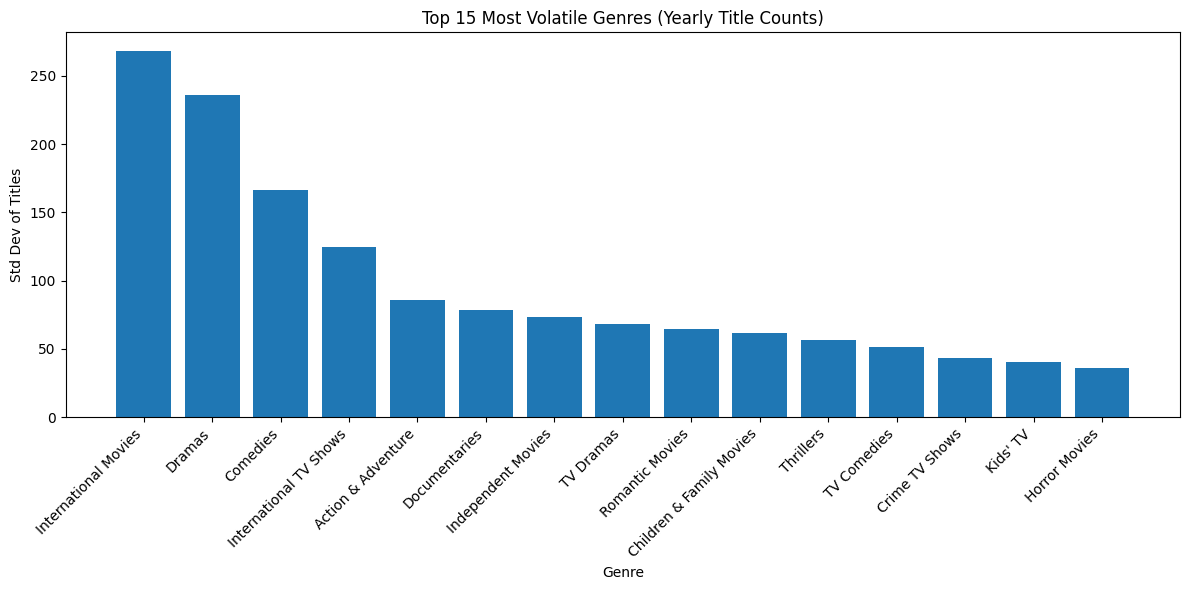

In [158]:
top15 = filtered_volatility.head(15)

plt.figure(figsize=(12,6))
plt.bar(top15.index.astype(str), top15.values)
plt.title("Top 15 Most Volatile Genres (Yearly Title Counts)")
plt.xlabel("Genre")
plt.ylabel("Std Dev of Titles")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [159]:
summary = pd.DataFrame({
    "total_titles": genre_growth.sum(axis=0),
    "avg_per_year": genre_growth.mean(axis=0),
    "volatility_std": genre_growth.std(axis=0)
}).sort_values("total_titles", ascending=False)

summary.head(15)


,total_titles,avg_per_year,volatility_std
genre,,,
International Movies,2752,196.571429,268.514923
Dramas,2427,173.357143,236.265368
Comedies,1674,119.571429,166.569327
International TV Shows,1328,94.857143,124.330117
Documentaries,869,62.071429,78.599730
Action & Adventure,859,61.357143,85.521574
Independent Movies,756,54.000000,73.609155
TV Dramas,739,52.785714,68.321839
Children & Family Movies,641,45.785714,61.953057


# COVID Impact Analysis (2019–2021)
Pre-COVID baseline (2017–2018)

COVID spike (2019–2020)

Post-spike adjustment (2021)

In [160]:
# Pivot: year vs genre title count
genre_year_counts = (
    df_genres
    .groupby(["added_year", "genre"])
    .size()
    .reset_index(name="title_count")
)

pivot = (
    genre_year_counts
    .pivot(index="added_year", columns="genre", values="title_count")
    .fillna(0)
)


/tmp/ipython-input-2888155177.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["added_year", "genre"])


In [161]:
# Define COVID Windows
pre_covid = pivot.loc[2017:2018].mean()
covid_peak = pivot.loc[2019:2020].mean()
post_covid = pivot.loc[2021].mean()

In [162]:
# Measure % Change
covid_impact = ((covid_peak - pre_covid) / pre_covid.replace(0, 1)) * 100
covid_impact = covid_impact.sort_values(ascending=False)

covid_impact.head(15)


,0
genre,
Classic Movies,284.210526
Teen TV Shows,270.000000
TV Horror,185.714286
Reality TV,177.551020
Anime Series,168.750000
TV Thrillers,150.000000
TV Action & Adventure,127.777778
Cult Movies,118.750000
TV Sci-Fi & Fantasy,100.000000


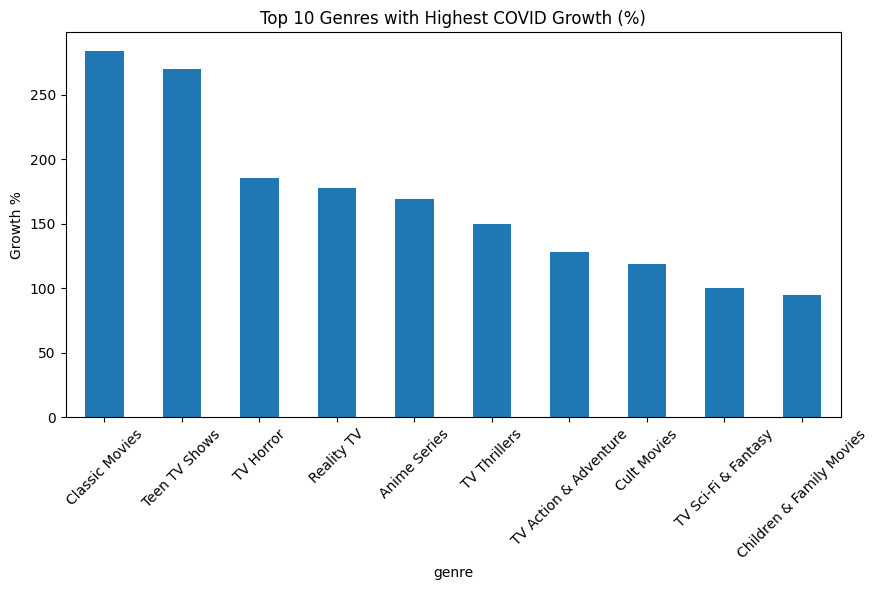

In [163]:
top_covid = covid_impact.head(10)

plt.figure(figsize=(10,5))
top_covid.plot(kind="bar")
plt.title("Top 10 Genres with Highest COVID Growth (%)")
plt.ylabel("Growth %")
plt.xticks(rotation=45)
plt.show()


Quadrant Classification

In [164]:
genre_summary = pd.DataFrame({
    "total_titles": pivot.sum(),
    "avg_per_year": pivot.mean(),
    "volatility_std": pivot.std()
})


In [165]:
# Define Threshold

avg_threshold = genre_summary["avg_per_year"].median()
vol_threshold = genre_summary["volatility_std"].median()


In [166]:
def classify(row):
    if row["avg_per_year"] >= avg_threshold and row["volatility_std"] >= vol_threshold:
        return "Growth Engine"
    elif row["avg_per_year"] >= avg_threshold and row["volatility_std"] < vol_threshold:
        return "Core Stable"
    elif row["avg_per_year"] < avg_threshold and row["volatility_std"] >= vol_threshold:
        return "Experimental"
    else:
        return "Niche"

genre_summary["strategy_segment"] = genre_summary.apply(classify, axis=1)

genre_summary.sort_values("avg_per_year", ascending=False).head(15)


,total_titles,avg_per_year,volatility_std,strategy_segment
genre,,,,
International Movies,2752,196.571429,268.514923,Growth Engine
Dramas,2427,173.357143,236.265368,Growth Engine
Comedies,1674,119.571429,166.569327,Growth Engine
International TV Shows,1328,94.857143,124.330117,Growth Engine
Documentaries,869,62.071429,78.599730,Growth Engine
Action & Adventure,859,61.357143,85.521574,Growth Engine
Independent Movies,756,54.000000,73.609155,Growth Engine
TV Dramas,739,52.785714,68.321839,Growth Engine
Children & Family Movies,641,45.785714,61.953057,Growth Engine


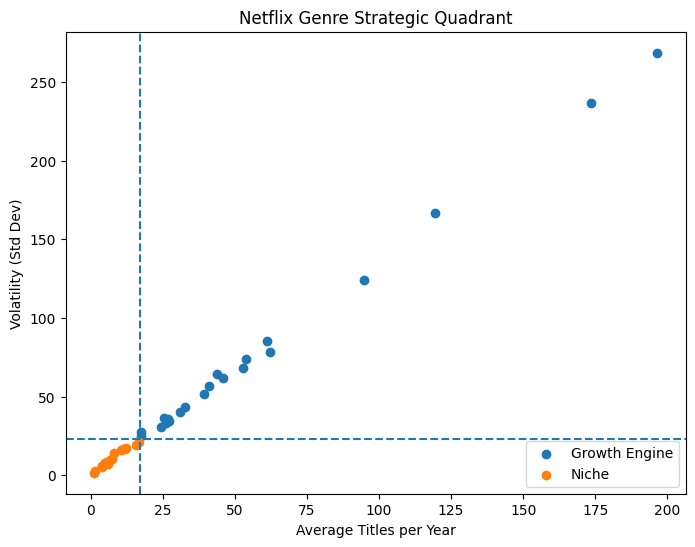

In [167]:
plt.figure(figsize=(8,6))

for segment in genre_summary["strategy_segment"].unique():
    subset = genre_summary[genre_summary["strategy_segment"] == segment]
    plt.scatter(subset["avg_per_year"], subset["volatility_std"], label=segment)

plt.axvline(avg_threshold, linestyle="--")
plt.axhline(vol_threshold, linestyle="--")

plt.xlabel("Average Titles per Year")
plt.ylabel("Volatility (Std Dev)")
plt.title("Netflix Genre Strategic Quadrant")
plt.legend()
plt.show()


Risk-Adjusted Growth Score

In [168]:
# Average yearly growth per genre
avg_growth = genre_growth.mean()

# Risk-adjusted score
risk_adjusted_score = (avg_growth / genre_volatility).sort_values(ascending=False)

risk_adjusted_score.head(10)


,0
genre,
Science & Nature TV,0.843045
British TV Shows,0.803015
Sports Movies,0.802201
Stand-Up Comedy,0.801153
Docuseries,0.791665
Documentaries,0.789716
TV Thrillers,0.786796
Romantic TV Shows,0.779042
TV Dramas,0.772604


In [169]:
# Pre vs Post COVID Structural Change

pre_covid = genre_growth.loc[genre_growth.index < 2020].mean()
post_covid = genre_growth.loc[genre_growth.index >= 2020].mean()

momentum_shift = (post_covid - pre_covid).sort_values(ascending=False)

momentum_shift.head(10)


,0
genre,
Dramas,350.166667
International Movies,344.083333
Comedies,277.583333
International TV Shows,183.916667
Action & Adventure,141.916667
Children & Family Movies,116.916667
Romantic Movies,116.083333
TV Dramas,114.000000
TV Comedies,96.500000


In [170]:
# Creating yearly pivot (counts per genre per year)
genre_year_counts = (
    df_genres
    .groupby(["added_year", "genre"])
    .size()
    .reset_index(name="title_count")
)

pivot_counts = genre_year_counts.pivot(
    index="added_year",
    columns="genre",
    values="title_count"
).fillna(0)

# Computing summary statistics
summary_df = pd.DataFrame({
    "total_titles": pivot_counts.sum(),
    "avg_per_year": pivot_counts.mean(),
    "volatility_std": pivot_counts.std()
}).sort_values("total_titles", ascending=False)

summary_df.head()


/tmp/ipython-input-74561097.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["added_year", "genre"])


,total_titles,avg_per_year,volatility_std
genre,,,
International Movies,2752,196.571429,268.514923
Dramas,2427,173.357143,236.265368
Comedies,1674,119.571429,166.569327
International TV Shows,1328,94.857143,124.330117
Documentaries,869,62.071429,78.599730


In [171]:
strategy_table = pd.DataFrame({
    "avg_titles_per_year": summary_df["avg_per_year"],
    "volatility": summary_df["volatility_std"],
    "avg_growth": avg_growth,
    "risk_adjusted_score": risk_adjusted_score,
    "covid_momentum_shift": momentum_shift
}).sort_values("risk_adjusted_score", ascending=False)

strategy_table.head(15)


,avg_titles_per_year,volatility,avg_growth,risk_adjusted_score,covid_momentum_shift
genre,,,,,
Science & Nature TV,6.214286,7.371239,6.214286,0.843045,9.083333
British TV Shows,16.785714,20.903362,16.785714,0.803015,23.583333
Sports Movies,15.642857,19.499930,15.642857,0.802201,23.166667
Stand-Up Comedy,24.500000,30.580914,24.500000,0.801153,9.333333
Docuseries,27.142857,34.285806,27.142857,0.791665,56.416667
Documentaries,62.071429,78.599730,62.071429,0.789716,54.166667
TV Thrillers,4.000000,5.083911,4.000000,0.786796,10.500000
Romantic TV Shows,26.000000,33.374334,26.000000,0.779042,43.750000
TV Dramas,52.785714,68.321839,52.785714,0.772604,114.000000


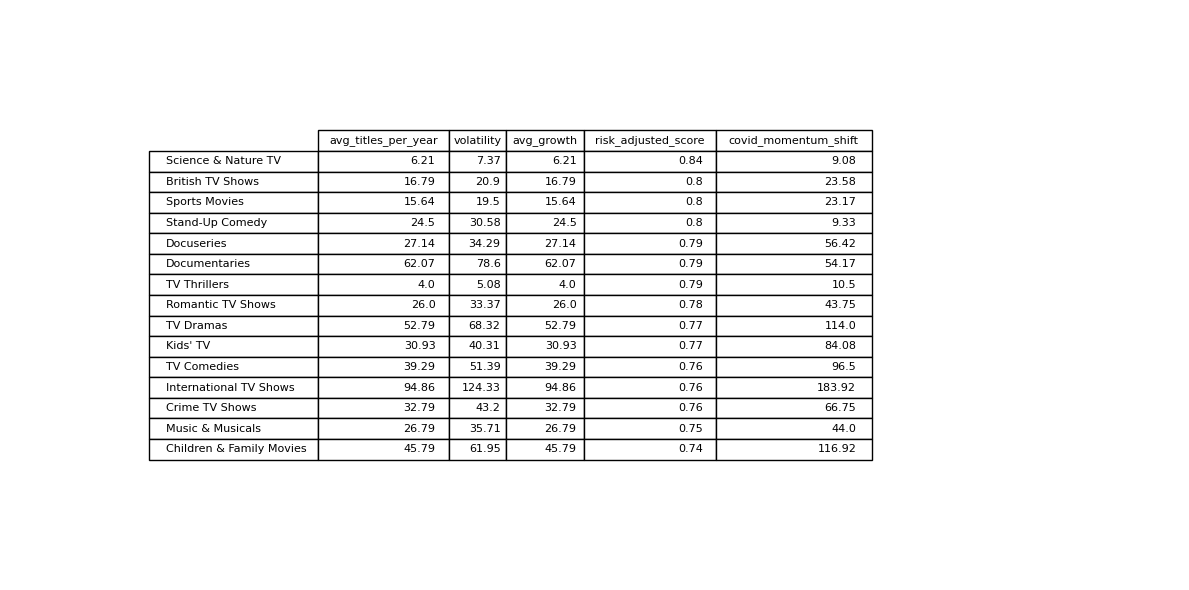

In [172]:
import matplotlib.pyplot as plt

# Take top 15 rows for cleaner visual
export_table = strategy_table.head(15)

fig, ax = plt.subplots(figsize=(12,6))
ax.axis('off')
table = ax.table(
    cellText=export_table.round(2).values,
    colLabels=export_table.columns,
    rowLabels=export_table.index,
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(8)
table.auto_set_column_width(col=list(range(len(export_table.columns))))

plt.tight_layout()
plt.savefig("strategy_table.png", dpi=300, bbox_inches="tight")
plt.show()


# Appendix – Gen-1 Exploratory Pipeline (Archived)

This section contains the initial exploratory version of the analysis.
It is preserved for reference and comparison.


In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from time import perf_counter
from dataclasses import dataclass

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

def timeit(fn):
    def wrapper(*args, **kwargs):
        t0 = perf_counter()
        out = fn(*args, **kwargs)
        t1 = perf_counter()
        print(f"✅ {fn.__name__} took {t1 - t0:.3f}s")
        return out
    return wrapper

def memory_mb(df: pd.DataFrame) -> float:
    return df.memory_usage(deep=True).sum() / (1024**2)

def report_df(df: pd.DataFrame, name="df"):
    print(f"--- {name} ---")
    print("shape:", df.shape)
    print("memory (MB):", round(memory_mb(df), 2))
    display(df.head(3))


In [174]:
df_raw = pd.read_csv("/content/netflix_titles.csv")

Refractor into Funtion

In [175]:
@timeit
def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = (
        df.columns.str.strip()
                 .str.lower()
                 .str.replace(" ", "_")
                 .str.replace("-", "_")
    )
    return df

@timeit
def parse_dates(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if "date_added" in df.columns:
        df["date_added"] = pd.to_datetime(df["date_added"], errors="coerce")
    return df

@timeit
def basic_cleaning(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # strip whitespace for common text columns if they exist
    text_cols = [c for c in ["type","title","director","cast","country","rating","duration","listed_in"] if c in df.columns]
    for c in text_cols:
        df[c] = df[c].astype("string").str.strip()

    # handle missing values (keep conservative defaults)
    if "country" in df.columns:
        df["country"] = df["country"].fillna("Unknown")
    if "director" in df.columns:
        df["director"] = df["director"].fillna("Unknown")
    if "cast" in df.columns:
        df["cast"] = df["cast"].fillna("Unknown")
    if "rating" in df.columns:
        df["rating"] = df["rating"].fillna("Unknown")
    if "listed_in" in df.columns:
        df["listed_in"] = df["listed_in"].fillna("Unknown")

    return df

@timeit
def clean_duration(df: pd.DataFrame) -> pd.DataFrame:
    """
    Splits duration into numeric value + unit.
    Movies: '90 min' -> 90, 'min'
    TV Shows: '2 Seasons' -> 2, 'Seasons'
    """
    df = df.copy()
    if "duration" not in df.columns:
        return df

    parts = df["duration"].astype("string").str.extract(r"(?P<dur_value>\d+)\s*(?P<dur_unit>.*)")
    df["dur_value"] = pd.to_numeric(parts["dur_value"], errors="coerce")
    df["dur_unit"] = parts["dur_unit"].astype("string").str.strip()
    return df


In [176]:
# Pipeline function
@timeit
def build_clean_df(df_raw: pd.DataFrame) -> pd.DataFrame:
    df = standardize_columns(df_raw)
    df = parse_dates(df)
    df = basic_cleaning(df)
    df = clean_duration(df)
    return df

df = build_clean_df(df_raw)
report_df(df, "df_clean")
df.info()


✅ standardize_columns took 0.005s
✅ parse_dates took 0.010s
✅ basic_cleaning took 0.032s
✅ clean_duration took 0.027s
✅ build_clean_df took 0.077s
--- df_clean ---
shape: (8807, 14)
memory (MB): 7.94


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,dur_value,dur_unit
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,Unknown,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",90,min
1,s2,TV Show,Blood & Water,Unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2,Seasons
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",Unknown,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,1,Season


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       8807 non-null   object        
 1   type          8807 non-null   string        
 2   title         8807 non-null   string        
 3   director      8807 non-null   string        
 4   cast          8807 non-null   string        
 5   country       8807 non-null   string        
 6   date_added    8709 non-null   datetime64[ns]
 7   release_year  8807 non-null   int64         
 8   rating        8807 non-null   string        
 9   duration      8804 non-null   string        
 10  listed_in     8807 non-null   string        
 11  description   8807 non-null   object        
 12  dur_value     8804 non-null   Int64         
 13  dur_unit      8804 non-null   string        
dtypes: Int64(1), datetime64[ns](1), int64(1), object(2), string(9)
memory usage: 972.0+ KB


In [177]:
# dtype optimization

@timeit
def optimize_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # use Int16/Int32 where safe
    if "release_year" in df.columns:
        df["release_year"] = pd.to_numeric(df["release_year"], errors="coerce").astype("Int16")

    if "dur_value" in df.columns:
        # duration can be small, Int16 ok
        df["dur_value"] = pd.to_numeric(df["dur_value"], errors="coerce").astype("Int16")

    # category conversion for low-cardinality columns
    cat_candidates = []
    for c in ["type", "rating", "dur_unit"]:
        if c in df.columns:
            cat_candidates.append(c)

    for c in cat_candidates:
        df[c] = df[c].astype("category")

    # string dtype for heavy text (better than object)
    for c in ["title", "director", "cast", "country", "listed_in", "description"]:
        if c in df.columns:
            df[c] = df[c].astype("string")

    return df

mem_before = memory_mb(df)
df_opt = optimize_dtypes(df)
mem_after = memory_mb(df_opt)

print(f"Memory before: {mem_before:.2f} MB")
print(f"Memory after : {mem_after:.2f} MB")
print(f"Saved       : {(mem_before-mem_after):.2f} MB ({(mem_before-mem_after)/mem_before*100:.1f}%)")
df_opt.info()


✅ optimize_dtypes took 0.020s
Memory before: 7.94 MB
Memory after : 6.53 MB
Saved       : 1.42 MB (17.8%)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       8807 non-null   object        
 1   type          8807 non-null   category      
 2   title         8807 non-null   string        
 3   director      8807 non-null   string        
 4   cast          8807 non-null   string        
 5   country       8807 non-null   string        
 6   date_added    8709 non-null   datetime64[ns]
 7   release_year  8807 non-null   Int16         
 8   rating        8807 non-null   category      
 9   duration      8804 non-null   string        
 10  listed_in     8807 non-null   string        
 11  description   8807 non-null   string        
 12  dur_value     8804 non-null   Int16         
 13  dur_unit      8804 non-null   ca

In [178]:
# Benchmarking a typical operation

@timeit
def titles_added_by_year(df: pd.DataFrame) -> pd.Series:
    if "date_added" not in df.columns:
        raise ValueError("date_added missing")
    return df.dropna(subset=["date_added"]).groupby(df["date_added"].dt.year)["show_id"].count()

# compare on df vs df_opt
_ = titles_added_by_year(df)      # original cleaned
_ = titles_added_by_year(df_opt)  # optimized


✅ titles_added_by_year took 0.014s
✅ titles_added_by_year took 0.010s


In [179]:
# Feature Engireering

@timeit
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # time features
    if "date_added" in df.columns:
        df["added_year"] = df["date_added"].dt.year.astype("Int16")
        df["added_month"] = df["date_added"].dt.month.astype("Int8")
        df["added_quarter"] = df["date_added"].dt.quarter.astype("Int8")
        df["added_year_month"] = df["date_added"].dt.to_period("M").astype("string")

    # content "freshness": gap between release and added year
    if "release_year" in df.columns and "added_year" in df.columns:
        df["release_to_added_gap"] = (df["added_year"] - df["release_year"]).astype("Int16")
        # bucketize for storytelling
        bins = [-100, 0, 1, 3, 6, 11, 1000]
        labels = ["Same year/earlier", "1", "2-3", "4-6", "7-11", "12+"]
        df["gap_bucket"] = pd.cut(df["release_to_added_gap"].astype("float"),
                                  bins=bins, labels=labels).astype("category")

    # multi-country feature
    if "country" in df.columns:
        # count countries per title
        df["country_count"] = df["country"].fillna("Unknown").str.split(",").apply(len).astype("Int16")
        df["is_multi_country"] = (df["country_count"] > 1)

        # primary country = first listed
        df["primary_country"] = df["country"].fillna("Unknown").str.split(",").str[0].str.strip().astype("string")

    # genre features
    if "listed_in" in df.columns:
        df["genre_count"] = df["listed_in"].fillna("Unknown").str.split(",").apply(len).astype("Int16")
        df["primary_genre"] = df["listed_in"].fillna("Unknown").str.split(",").str[0].str.strip().astype("string")

    # standardized "minutes" for movies only (optional)
    if "type" in df.columns and "dur_value" in df.columns and "dur_unit" in df.columns:
        is_movie = df["type"].astype("string").str.lower().eq("movie")
        df["movie_minutes"] = np.where(is_movie & df["dur_unit"].astype("string").str.contains("min", case=False, na=False),
                                       df["dur_value"].astype("float"),
                                       np.nan)

    return df

df_feat = add_features(df_opt)
report_df(df_feat, "df_features")
df_feat[["type","date_added","added_year","release_year","release_to_added_gap","gap_bucket","country_count","is_multi_country","primary_country","genre_count","primary_genre","movie_minutes"]].head(5)


✅ add_features took 0.357s
--- df_features ---
shape: (8807, 26)
memory (MB): 8.24


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,dur_value,dur_unit,added_year,added_month,added_quarter,added_year_month,release_to_added_gap,gap_bucket,country_count,is_multi_country,primary_country,genre_count,primary_genre,movie_minutes
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,Unknown,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",90,min,2021,9,3,2021-09,1,1,1,False,United States,1,Documentaries,90.0
1,s2,TV Show,Blood & Water,Unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2,Seasons,2021,9,3,2021-09,0,Same year/earlier,1,False,South Africa,3,International TV Shows,NaN
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",Unknown,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,1,Season,2021,9,3,2021-09,0,Same year/earlier,1,False,Unknown,3,Crime TV Shows,NaN


,type,date_added,added_year,release_year,release_to_added_gap,gap_bucket,country_count,is_multi_country,primary_country,genre_count,primary_genre,movie_minutes
0,Movie,2021-09-25,2021,2020,1,1,1,False,United States,1,Documentaries,90.0
1,TV Show,2021-09-24,2021,2021,0,Same year/earlier,1,False,South Africa,3,International TV Shows,NaN
2,TV Show,2021-09-24,2021,2021,0,Same year/earlier,1,False,Unknown,3,Crime TV Shows,NaN
3,TV Show,2021-09-24,2021,2021,0,Same year/earlier,1,False,Unknown,2,Docuseries,NaN
4,TV Show,2021-09-24,2021,2021,0,Same year/earlier,1,False,India,3,International TV Shows,NaN


In [180]:
@timeit
def explode_column(df: pd.DataFrame, col: str, new_col: str) -> pd.DataFrame:
    """
    Explode a comma-separated column into long format.
    """
    out = df[["show_id", "type", "title", col]].copy()
    out[col] = out[col].fillna("Unknown").astype("string")
    out[new_col] = out[col].str.split(",")
    out = out.explode(new_col)
    out[new_col] = out[new_col].astype("string").str.strip()
    return out.drop(columns=[col])

genres_long = explode_column(df_feat, "listed_in", "genre")
countries_long = explode_column(df_feat, "country", "country_name")

display(genres_long.head(5))
display(countries_long.head(5))


✅ explode_column took 0.041s
✅ explode_column took 0.027s


,show_id,type,title,genre
0,s1,Movie,Dick Johnson Is Dead,Documentaries
1,s2,TV Show,Blood & Water,International TV Shows
1,s2,TV Show,Blood & Water,TV Dramas
1,s2,TV Show,Blood & Water,TV Mysteries
2,s3,TV Show,Ganglands,Crime TV Shows


,show_id,type,title,country_name
0,s1,Movie,Dick Johnson Is Dead,United States
1,s2,TV Show,Blood & Water,South Africa
2,s3,TV Show,Ganglands,Unknown
3,s4,TV Show,Jailbirds New Orleans,Unknown
4,s5,TV Show,Kota Factory,India


In [181]:
df.memory_usage(deep=True).sort_values(ascending=False).head(10)


,0
description,1873527
cast,1442187
listed_in,725748
title,593134
director,551401
country,537701
duration,493558
type,480930
show_id,474471
rating,470610


In [182]:
df.isna().sum().sort_values(ascending=False).head(10)



,0
date_added,98
duration,3
dur_unit,3
dur_value,3
show_id,0
type,0
country,0
cast,0
director,0
title,0


In [183]:
# Convert high-cardinality text columns

text_cols = ["show_id","title","director","cast","country","listed_in","description"]

for c in text_cols:
    if c in df.columns:
        df[c] = df[c].astype("string").str.strip()


In [184]:
# Downcast numerics
num_cols = ["release_year", "added_year", "added_month", "dur_value", "content_age"]

for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce", downcast="integer")

In [185]:
cat_cols = ["type", "rating", "dur_unit"]

for c in cat_cols:
    if c in df.columns:
        df[c] = df[c].astype("category")


In [186]:
# before vs after” memory print
def mem_mb(d):
    return d.memory_usage(deep=True).sum() / (1024**2)

print(f"Memory: {mem_mb(df):.2f} MB")


Memory: 6.52 MB


In [187]:
# split lists
df["country_list"] = df["country"].fillna("").str.split(", ")
df["genre_list"] = df["listed_in"].fillna("").str.split(", ")


In [188]:
# Advanced Feature Engineering: A) Countries (multi-country titles)
import pandas as pd
import numpy as np

# clean country
df["country_clean"] = (
    df["country"]
    .fillna("Unknown")
    .astype("string")
    .str.strip()
)

# split to list, then explode
df_countries = (
    df.assign(country_clean=df["country_clean"].str.split(",\s*"))
      .explode("country_clean")
      .rename(columns={"country_clean": "country_exploded"})
)

df_countries["country_exploded"] = df_countries["country_exploded"].fillna("Unknown").str.strip()
df_countries.head()


<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2661488822.py:15: SyntaxWarning: invalid escape sequence '\s'
  df.assign(country_clean=df["country_clean"].str.split(",\s*"))


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,dur_value,dur_unit,country_list,genre_list,country_exploded
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,Unknown,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",90,min,[United States],[Documentaries],United States
1,s2,TV Show,Blood & Water,Unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2,Seasons,[South Africa],"[International TV Shows, TV Dramas, TV Mysteries]",South Africa
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",Unknown,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,1,Season,[Unknown],"[Crime TV Shows, International TV Shows, TV Ac...",Unknown
3,s4,TV Show,Jailbirds New Orleans,Unknown,Unknown,Unknown,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",1,Season,[Unknown],"[Docuseries, Reality TV]",Unknown
4,s5,TV Show,Kota Factory,Unknown,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2,Seasons,[India],"[International TV Shows, Romantic TV Shows, TV...",India


Text(0, 0.5, 'Country')

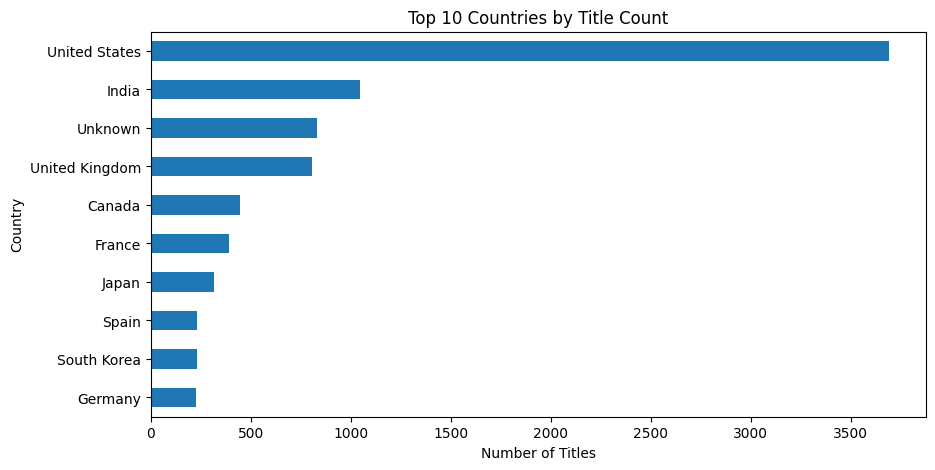

In [189]:
# Top 10 countries by content count
top10 = df_countries["country_exploded"].value_counts().head(10)

ax = top10.sort_values().plot(kind="barh", figsize=(10,5), title="Top 10 Countries by Title Count")
ax.set_xlabel("Number of Titles")
ax.set_ylabel("Country")


<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1491947976.py:6: SyntaxWarning: invalid escape sequence '\s'
  df["country_clean"].str.split(",\s*").apply(len).values


Text(0, 0.5, 'Titles Added')

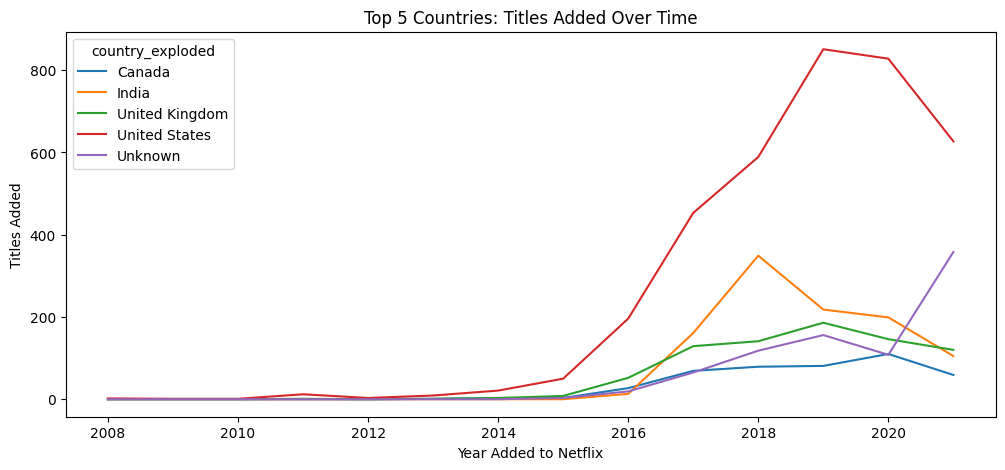

In [190]:
# Country trend over time (Top 5 countries by year added)
if "added_year" not in df.columns:
    df["added_year"] = pd.to_datetime(df["date_added"], errors="coerce").dt.year

df_countries["added_year"] = df["added_year"].values.repeat(
    df["country_clean"].str.split(",\s*").apply(len).values
)

top5_countries = df_countries["country_exploded"].value_counts().head(5).index

country_year = (df_countries[df_countries["country_exploded"].isin(top5_countries)]
                .groupby(["added_year","country_exploded"])
                .size()
                .unstack(fill_value=0)
               )

ax = country_year.plot(figsize=(12,5), title="Top 5 Countries: Titles Added Over Time")
ax.set_xlabel("Year Added to Netflix")
ax.set_ylabel("Titles Added")


When split across multi-country titles, the top countries dominate overall volume, and trends show how Netflix’s additions shifted over time by region


In [191]:
# B: Genre feature engineering

import pandas as pd

df["genre_clean"] = (
    df["listed_in"]
    .fillna("Unknown")
    .astype("string")
    .str.strip()
)

df_genres = (
    df.assign(genre_clean=df["genre_clean"].str.split(",\s*"))
      .explode("genre_clean")
      .rename(columns={"genre_clean": "genre"})
)

df_genres["genre"] = df_genres["genre"].fillna("Unknown").str.strip()
df_genres[["show_id", "type", "title", "genre"]].head()


<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-834978739.py:13: SyntaxWarning: invalid escape sequence '\s'
  df.assign(genre_clean=df["genre_clean"].str.split(",\s*"))


,show_id,type,title,genre
0,s1,Movie,Dick Johnson Is Dead,Documentaries
1,s2,TV Show,Blood & Water,International TV Shows
1,s2,TV Show,Blood & Water,TV Dramas
1,s2,TV Show,Blood & Water,TV Mysteries
2,s3,TV Show,Ganglands,Crime TV Shows


Text(0, 0.5, 'Genre')

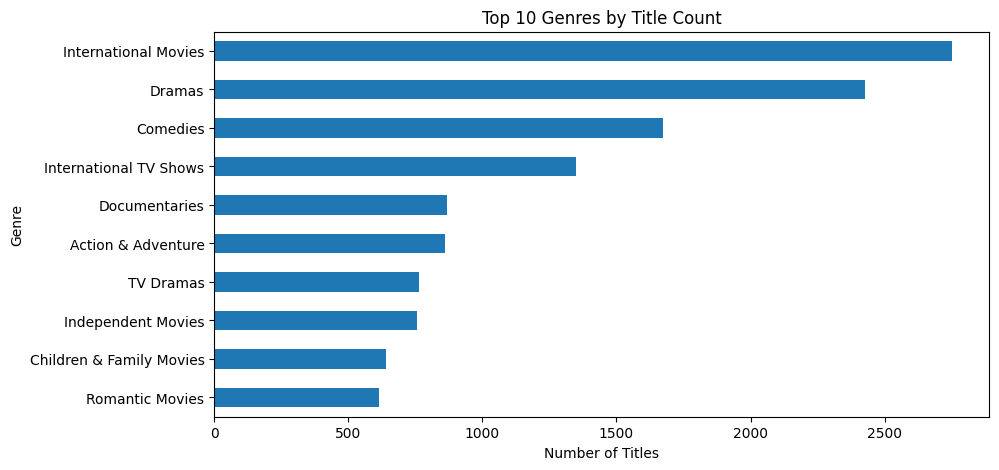

In [192]:
# Top 10 genre by title count
top10_genres = df_genres["genre"].value_counts().head(10)

ax = top10_genres.sort_values().plot(kind="barh", figsize=(10,5), title="Top 10 Genres by Title Count")
ax.set_xlabel("Number of Titles")
ax.set_ylabel("Genre")


/tmp/ipython-input-665748163.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_genres.groupby(["type", "genre"])


Text(0, 0.5, 'Number of Titles')

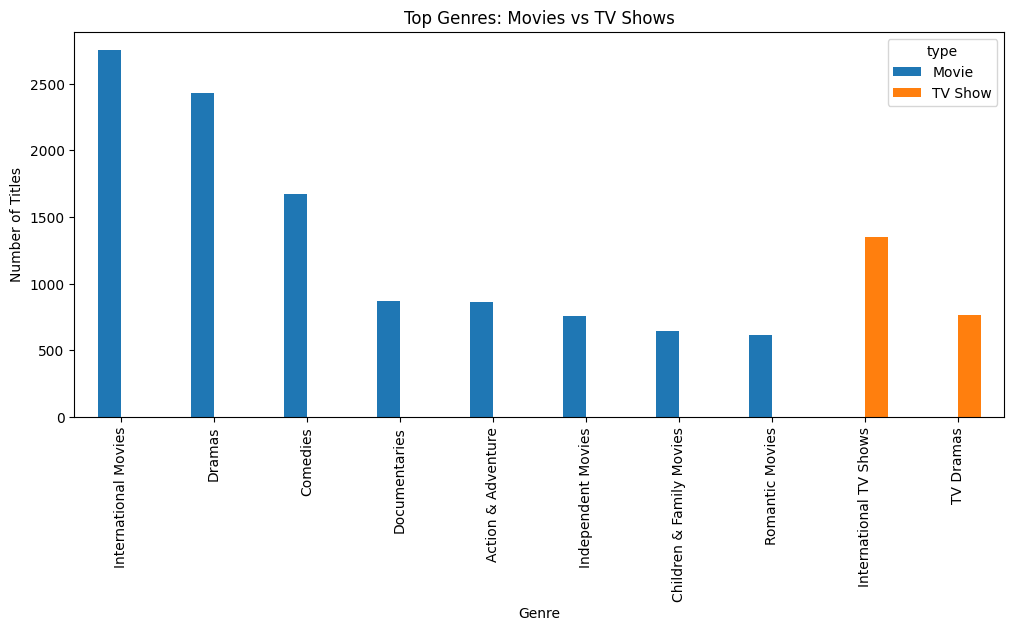

In [193]:
# Top 10 genres split by content type (Movie vs TV Show)
genre_by_type = (
    df_genres.groupby(["type", "genre"])
             .size()
             .reset_index(name="count")
)

top_genres_overall = df_genres["genre"].value_counts().head(10).index
genre_by_type_top = genre_by_type[genre_by_type["genre"].isin(top_genres_overall)]

pivot = genre_by_type_top.pivot(index="genre", columns="type", values="count").fillna(0)

ax = pivot.sort_values(by=pivot.columns.tolist(), ascending=False).plot(
    kind="bar", figsize=(12,5), title="Top Genres: Movies vs TV Shows"
)
ax.set_xlabel("Genre")
ax.set_ylabel("Number of Titles")


<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2063283296.py:7: SyntaxWarning: invalid escape sequence '\s'
  df["genre_clean"].str.split(",\s*").apply(len).values


Text(0, 0.5, 'Titles Added')

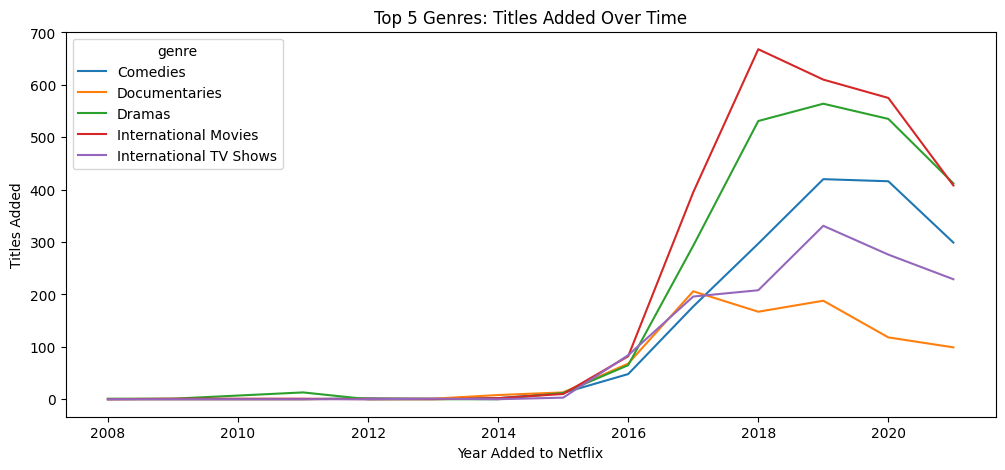

In [194]:
# Genre trend over time (Top 5 genres)
if "added_year" not in df.columns:
    df["added_year"] = pd.to_datetime(df["date_added"], errors="coerce").dt.year

# attach year to exploded rows (same index so it aligns)
df_genres["added_year"] = df["added_year"].values.repeat(
    df["genre_clean"].str.split(",\s*").apply(len).values
)

top5_genres = df_genres["genre"].value_counts().head(5).index

genre_year = (df_genres[df_genres["genre"].isin(top5_genres)]
              .groupby(["added_year", "genre"])
              .size()
              .unstack(fill_value=0)
             )

ax = genre_year.plot(figsize=(12,5), title="Top 5 Genres: Titles Added Over Time")
ax.set_xlabel("Year Added to Netflix")
ax.set_ylabel("Titles Added")


After exploding multi-genre titles, a few genres dominate the catalog, and the year-wise trend shows how Netflix’s content mix shifted over time

In [195]:
def parse_duration(df):
    df = df.copy()

    # Ensure duration is string
    df["duration"] = df["duration"].astype("string")

    # Extract numeric value
    df["dur_value"] = (
        df["duration"]
        .str.extract(r"(\d+)")
        .astype("Int64")
    )

    # Extract unit
    df["dur_unit"] = (
        df["duration"]
        .str.extract(r"(min|Season|Seasons)")
    )

    return df

df = parse_duration(df)
df[["duration", "dur_value", "dur_unit"]].head()


,duration,dur_value,dur_unit
0,90 min,90,min
1,2 Seasons,2,Season
2,1 Season,1,Season
3,1 Season,1,Season
4,2 Seasons,2,Season


In [196]:
# Standardizing the units

def engineer_duration_features(df):
    df = df.copy()

    # Movie length bucket
    df["movie_length_bucket"] = pd.cut(
        df["dur_value"],
        bins=[0, 60, 90, 120, 180, 1000],
        labels=["Very Short", "Short", "Standard", "Long", "Very Long"]
    )

    # TV season bucket
    df["tv_season_bucket"] = pd.cut(
        df["dur_value"],
        bins=[0, 1, 3, 5, 10, 50],
        labels=["Limited", "Short Series", "Mid Series", "Long Series", "Very Long Series"]
    )

    return df



In [197]:
df = engineer_duration_features(df)

/tmp/ipython-input-2247193224.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("movie_length_bucket")["rating"]


<Axes: title={'center': 'Movie Count by Length Bucket'}, xlabel='movie_length_bucket'>

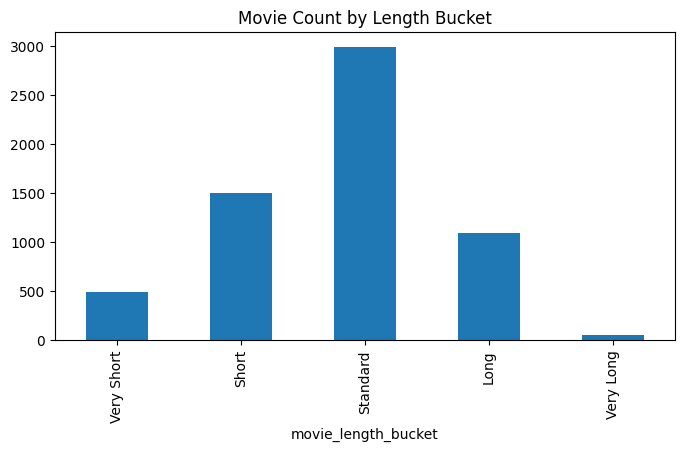

In [198]:
# Comparing Duration vs Popularity

# Movies
movie_popularity = (
    df[df["type"] == "Movie"]
    .groupby("movie_length_bucket")["rating"]
    .count()
)

movie_popularity.plot(kind="bar", figsize=(8,4), title="Movie Count by Length Bucket")


/tmp/ipython-input-1393277549.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("tv_season_bucket")["rating"]


<Axes: title={'center': 'TV Shows by Season Bucket'}, xlabel='tv_season_bucket'>

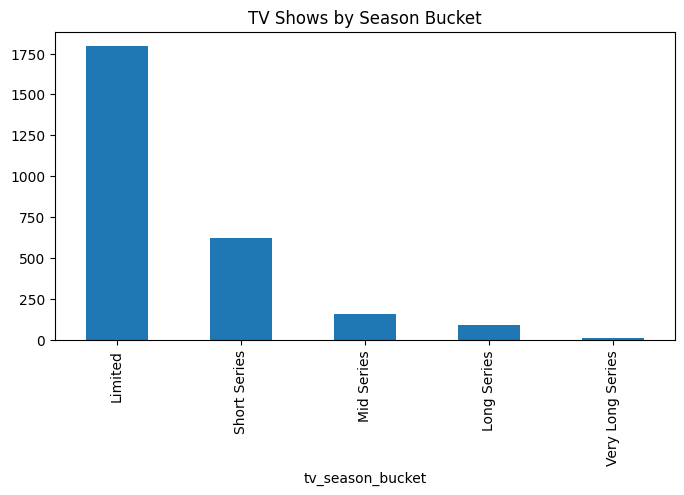

In [199]:
# TV Shows

tv_popularity = (
    df[df["type"] == "TV Show"]
    .groupby("tv_season_bucket")["rating"]
    .count()
)

tv_popularity.plot(kind="bar", figsize=(8,4), title="TV Shows by Season Bucket")


In [200]:
# Strategic Feature: Content Age
def add_content_age(df):
    df = df.copy()

    df["content_age"] = df["added_year"] - df["release_year"]

    df["content_age_bucket"] = pd.cut(
        df["content_age"],
        bins=[-1, 1, 5, 10, 20, 100],
        labels=["New Release", "Recent", "Moderate Age", "Old", "Classic"]
    )

    return df
df = add_content_age(df)

/tmp/ipython-input-19577661.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("content_age_bucket")


<Axes: title={'center': 'Content Age Distribution on Netflix'}, xlabel='content_age_bucket'>

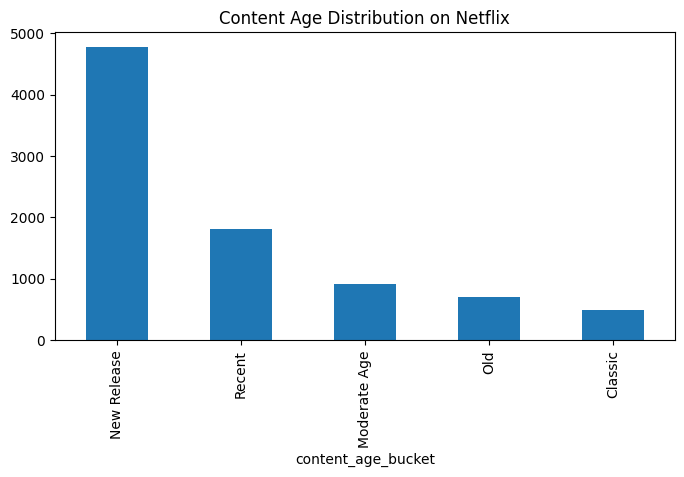

In [201]:
age_distribution = (
    df.groupby("content_age_bucket")
      .size()
)

age_distribution.plot(kind="bar", figsize=(8,4), title="Content Age Distribution on Netflix")


In [202]:
# Genre Evolution Heatmap

df["added_year"] = pd.to_datetime(df["date_added"], errors="coerce").dt.year

df_genres = (
    df.assign(genre=df["listed_in"].str.split(",\s*"))
      .explode("genre")
)

df_genres["genre"] = df_genres["genre"].str.strip()


<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2947857351.py:6: SyntaxWarning: invalid escape sequence '\s'
  df.assign(genre=df["listed_in"].str.split(",\s*"))


In [203]:
# Getting top genres
top_genres = df_genres["genre"].value_counts().head(10).index

df_genres_top = df_genres[df_genres["genre"].isin(top_genres)]


In [204]:
# Year x genres matrix
genre_year_matrix = (
    df_genres_top
    .groupby(["added_year", "genre"])
    .size()
    .unstack(fill_value=0)
)


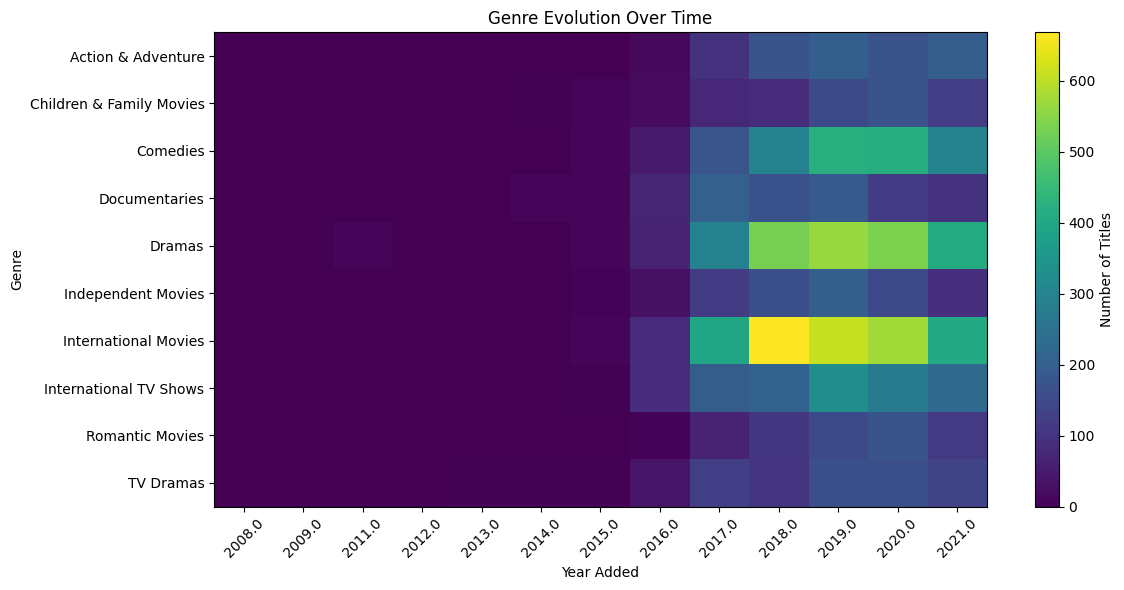

In [205]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.imshow(genre_year_matrix.T, aspect='auto')

plt.xticks(
    range(len(genre_year_matrix.index)),
    genre_year_matrix.index,
    rotation=45
)

plt.yticks(
    range(len(genre_year_matrix.columns)),
    genre_year_matrix.columns
)

plt.colorbar(label="Number of Titles")
plt.title("Genre Evolution Over Time")
plt.xlabel("Year Added")
plt.ylabel("Genre")

plt.tight_layout()
plt.show()


#Insights
1. Post-2016 surge concentrated heavily in Drama and
International TV.

2. Documentaries show steady but moderate growth.

3. Action & Adventure accelerated during expansion years.





In [206]:
# Converting into reusable Pipeline

def build_netflix_pipeline(csv_path):
    df = pd.read_csv(csv_path)

    df = clean_netflix_data(df)
    df = optimize_dtypes(df)
    df = add_features(df)

    return df


In [207]:
def build_genre_long_table(df):
    df_genres = (
        df.assign(genre=df["listed_in"].str.split(",\s*"))
          .explode("genre")
    )
    df_genres["genre"] = df_genres["genre"].str.strip()
    return df_genres


<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-387316709.py:3: SyntaxWarning: invalid escape sequence '\s'
  df.assign(genre=df["listed_in"].str.split(",\s*"))


In [208]:
def build_country_long_table(df):
    df_countries = (
        df.assign(country=df["country"].str.split(",\s*"))
          .explode("country")
    )
    df_countries["country"] = df_countries["country"].str.strip()
    return df_countries


<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-4166820598.py:3: SyntaxWarning: invalid escape sequence '\s'
  df.assign(country=df["country"].str.split(",\s*"))


In [209]:
def plot_genre_heatmap(df_genres, top_n=10):
    top_genres = df_genres["genre"].value_counts().head(top_n).index

    matrix = (
        df_genres[df_genres["genre"].isin(top_genres)]
        .groupby(["added_year", "genre"])
        .size()
        .unstack(fill_value=0)
    )

    plt.figure(figsize=(12,6))
    plt.imshow(matrix.T, aspect='auto')
    plt.xticks(range(len(matrix.index)), matrix.index, rotation=45)
    plt.yticks(range(len(matrix.columns)), matrix.columns)
    plt.colorbar(label="Titles")
    plt.title("Genre Evolution Heatmap")
    plt.tight_layout()
    plt.show()


In [210]:
def clean_netflix_data(df):
    df = df.copy()

    # Drop duplicates
    df = df.drop_duplicates()

    # Fix missing dates
    df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')

    # Clean duration split if not already done
    df[['dur_value', 'dur_unit']] = df['duration'].str.extract(r'(\d+)\s*(\w+)')
    df['dur_value'] = pd.to_numeric(df['dur_value'], errors='coerce')

    return df


✅ optimize_dtypes took 0.033s
✅ add_features took 0.193s


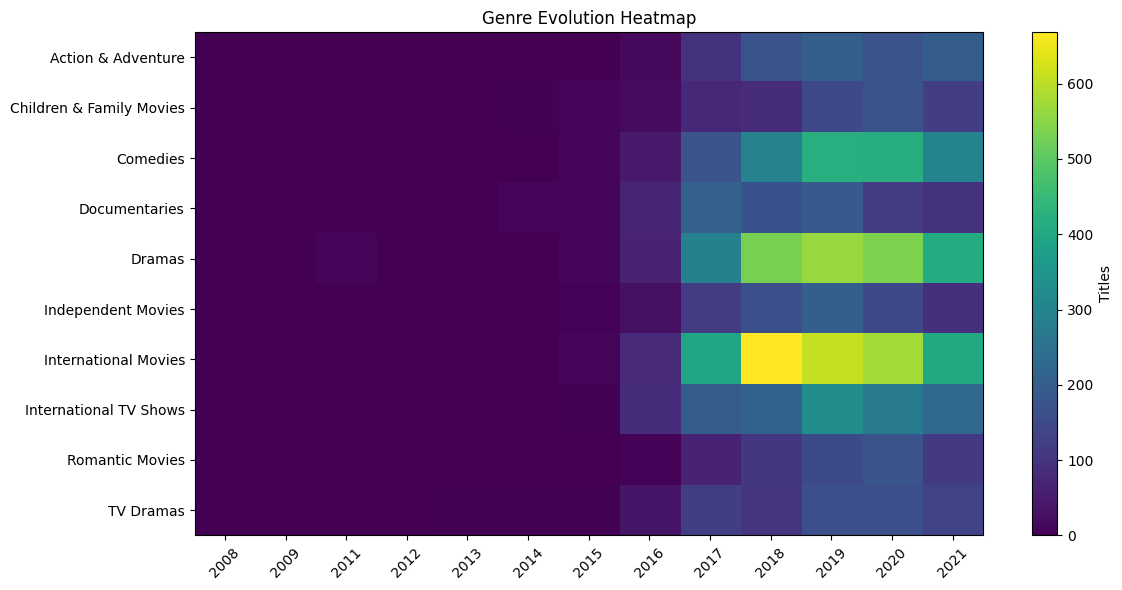

In [211]:
df = build_netflix_pipeline("netflix_titles.csv")

df_genres = build_genre_long_table(df)
df_countries = build_country_long_table(df)

plot_genre_heatmap(df_genres)


In [212]:
# Pipeline summary
print("Rows:", len(df))
print("Columns:", df.shape[1])
print("Date range:", df["date_added"].min(), "→", df["date_added"].max())
print("Types:", df["type"].value_counts().to_dict())


Rows: 8807
Columns: 26
Date range: 2008-01-01 00:00:00 → 2021-09-25 00:00:00
Types: {'Movie': 6131, 'TV Show': 2676}
